In [3]:
from datetime import timedelta
import polars as pl
import implicit
import json
import pandas as pd


DATA_DIR = 'data/'

# df_test_users = pl.read_parquet(f'{DATA_DIR}/test_users.pq')
# df_clickstream = pl.read_parquet(f'{DATA_DIR}/clickstream.pq')

df_cat_features = pl.read_parquet(f'{DATA_DIR}/cat_features.pq')
df_text_features = pl.read_parquet(f'{DATA_DIR}/text_features.pq')
df_event = pl.read_parquet(f'{DATA_DIR}/events.pq')

# Get clean attributed data

In [2]:
df_cat_features

item,location,category,clean_params,node
i64,i64,i64,str,u32
9,8385,57,"""[{""attr"":1157,""value"":664427},…",194747
17,2707,35,"""[{""attr"":2140,""value"":501466},…",352905
144,8383,8,"""[{""attr"":802,""value"":35791},{""…",17188
202,5397,57,"""[{""attr"":1157,""value"":490527},…",194766
236,2105,64,"""[{""attr"":112,""value"":420797},{…",153951
…,…,…,…,…
28804461,24,35,"""[{""attr"":2140,""value"":364348},…",326792
28804502,2305,51,"""[{""attr"":4622,""value"":171723},…",401208
28804563,2348,0,"""[{""attr"":914,""value"":93691},{""…",13974


In [3]:
df_cat_features[0, "clean_params"]

'[{"attr":1157,"value":664427},{"attr":4682,"value":326570},{"attr":3512,"value":18427},{"attr":2557,"value":730975},{"attr":4516,"value":300310},{"attr":998,"value":522797},{"attr":4926,"value":19276},{"attr":3367,"value":500290},{"attr":3206,"value":497888},{"attr":4848,"value":136279},{"attr":1253,"value":3026},{"attr":2549,"value":213759}]'

In [4]:
pl.DataFrame(json.loads(df_cat_features[1, "clean_params"]))

attr,value
i64,i64
2140,501466
1897,582135
1550,498267
567,173798
2278,533341
3911,725581
704,270613
622,184975
3316,330006


In [5]:
df_cat_features[0, "clean_params"]

'[{"attr":1157,"value":664427},{"attr":4682,"value":326570},{"attr":3512,"value":18427},{"attr":2557,"value":730975},{"attr":4516,"value":300310},{"attr":998,"value":522797},{"attr":4926,"value":19276},{"attr":3367,"value":500290},{"attr":3206,"value":497888},{"attr":4848,"value":136279},{"attr":1253,"value":3026},{"attr":2549,"value":213759}]'

In [6]:

pl.DataFrame(json.loads(df_cat_features[0, "clean_params"]))

attr,value
i64,i64
1157,664427
4682,326570
3512,18427
2557,730975
4516,300310
…,…
3367,500290
3206,497888
4848,136279


In [57]:
attr_col = "clean_params"
prefix = "attr_"
chunk_size = 500000
top_n = 20

In [56]:
from tqdm import tqdm
from collections import Counter
counter = Counter()
total_rows = df_cat_features.height

# Iterate in chunks, update counter
for offset in tqdm(range(0, total_rows, chunk_size)):
    chunk = df_cat_features.slice(offset, chunk_size)[attr_col].to_list()
    for json_str in chunk:
        try:
            items = json.loads(json_str)
            # count each attr occurrence
            for d in items:
                counter[d.get("attr")] += 1
        except Exception:
            continue

100%|██████████| 227/227 [01:09<00:00,  3.27it/s]


NameError: name 'top_n' is not defined

In [82]:
(pd.DataFrame(dict(counter).items()).set_index(0)[1] / total_rows).sort_values().tail(top_n) * 100

0
3640     5.135518
3939     5.242620
1598     5.249385
3154     5.568107
124      5.655365
3509     5.655369
1092     5.655374
1971     6.394369
2140     7.855677
3911     7.856093
4622    10.341264
3025    10.341268
3392    10.341268
3031    12.404536
567     16.311085
1897    16.311094
1550    16.311094
1433    19.784255
2278    22.029947
704     22.327977
Name: 1, dtype: float64

In [83]:
top_attrs = [attr for attr, _ in counter.most_common(top_n)]
top_attrs

[704,
 2278,
 1433,
 1897,
 1550,
 567,
 3031,
 3392,
 3025,
 4622,
 3911,
 2140,
 1971,
 1092,
 3509,
 124,
 3154,
 1598,
 3939,
 3640]

In [91]:
# unique_attrs = count_unique_attrs_chunked(df, attr_col, chunk_size)
attr_cols = [f"{prefix}{aid}" for aid in top_attrs]
results = []
total_rows = df_cat_features.height

for offset in tqdm(range(0, total_rows, chunk_size)):
    # 1) Slice a chunk into pandas for JSON parsing
    sub_pdf = df_cat_features.slice(offset, chunk_size).to_pandas()
    dicts = []
    for json_str in sub_pdf[attr_col]:
        row_dict = {}
        try:
            items = json.loads(json_str)
            for d in items:
                aid = d.get("attr")
                if aid in top_attrs:
                    row_dict[f"{prefix}{aid}"] = d.get("value")
        except Exception:
            pass
        dicts.append(row_dict)

    # 2) Convert dicts to Polars
    wide_chunk = pl.DataFrame(dicts)

    # 3) Ensure all selected columns present
    for col in attr_cols:
        if col not in wide_chunk.columns:
            wide_chunk = wide_chunk.with_columns(pl.lit(None).alias(col))

    # 4) Combine with original slice
    left = df_cat_features.slice(offset, chunk_size).drop(attr_col)
    results.append(pl.concat([left, wide_chunk[attr_cols]], how="horizontal"))


100%|██████████| 46/46 [01:37<00:00,  2.12s/it]


In [92]:
attribute_df = pl.concat(results, how="vertical")

In [103]:
attribute_df.null_count()

item,location,category,node,attr_704,attr_2278,attr_1433,attr_1897,attr_1550,attr_567,attr_3031,attr_3392,attr_3025,attr_4622,attr_3911,attr_2140,attr_1971,attr_1092,attr_3509,attr_124,attr_3154,attr_1598,attr_3939,attr_3640
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,1,1,0,17590143,17657637,18166212,18952768,18952768,18952770,19837474,20304736,20304736,20304737,20867546,20867640,21198578,21365936,21365937,21365938,21385699,21457879,21459411,21509072


In [105]:
attribute_df = attribute_df.fill_null(0)

In [106]:
df_cat_features["item", "location", "category"]

item,location,category
i64,i64,i64
9,8385,57
17,2707,35
144,8383,8
202,5397,57
236,2105,64
…,…,…
28804461,24,35
28804502,2305,51
28804563,2348,0


In [107]:
def assert_fields_equal(
    orig: pl.DataFrame,
    new: pl.DataFrame,
    fields: list[str]
) -> None:
    """
    Assert that the given fields are identical between two DataFrames row-wise.

    Raises AssertionError if any mismatch is found, showing example rows.

    Parameters
    ----------
    orig : pl.DataFrame
        Original DataFrame.
    new : pl.DataFrame
        Parsed/modified DataFrame.
    fields : list[str]
        Column names to compare.
    """
    # select and reorder
    o = orig.select(fields)
    n = new.select(fields)

    # ensure same shape
    if o.shape != n.shape:
        raise AssertionError(f"Shape mismatch on fields {fields}: orig {o.shape}, new {n.shape}")

    # find mismatches
    diffs = []
    for col in tqdm(fields):
        mask = (o[col] != n[col]) & ~(o[col].is_null() & n[col].is_null())
        if mask.any():
            idx = mask.arg_true()[0]
            diffs.append((col, idx, o[col][idx], n[col][idx]))

    if diffs:
        msg = "Mismatches found:\n"
        for col, idx, ov, nv in diffs:
            msg += f" - Field '{col}' at row {idx}: orig={ov}, new={nv}\n"
        raise AssertionError(msg)

In [115]:
assert_fields_equal(df_cat_features, attribute_df, ["item", "location", "category", "node"])

100%|██████████| 4/4 [00:00<00:00, 191.56it/s]


In [123]:
attribute_df.write_parquet(f"./data/cat_features_preproc_{top_n}.pq")

# Text features

In [126]:
attribute_df

item,location,category,node,attr_704,attr_2278,attr_1433,attr_1897,attr_1550,attr_567,attr_3031,attr_3392,attr_3025,attr_4622,attr_3911,attr_2140,attr_1971,attr_1092,attr_3509,attr_124,attr_3154,attr_1598,attr_3939,attr_3640
i64,i64,i64,u32,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
9,8385,57,194747,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17,2707,35,352905,270613,533341,0,582135,498267,173798,0,0,0,0,725581,501466,0,0,0,0,0,0,0,0
144,8383,8,17188,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
202,5397,57,194766,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
236,2105,64,153951,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
28804461,24,35,326792,249640,737256,498743,582135,498267,318315,0,0,0,0,725581,364348,0,0,0,0,0,0,0,0
28804502,2305,51,401208,0,0,0,0,0,0,0,488527,770753,171723,0,0,0,0,0,0,0,247180,0,0
28804563,2348,0,13974,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [128]:
df_text_features

item,title_projection
i64,"array[i8, 64]"
9,"[-128, 90, … -36]"
17,"[-128, 127, … -3]"
144,"[-128, 97, … 18]"
202,"[-128, 127, … 15]"
236,"[-128, 29, … -128]"
…,…
28804461,"[-128, 127, … 99]"
28804502,"[-69, -128, … -37]"
28804563,"[-96, 72, … -49]"


# Location

In [4]:
attribute_df = pl.read_parquet(f'{DATA_DIR}/items_preproc_20.pq')

In [11]:
import matplotlib.pyplot as plt

[]

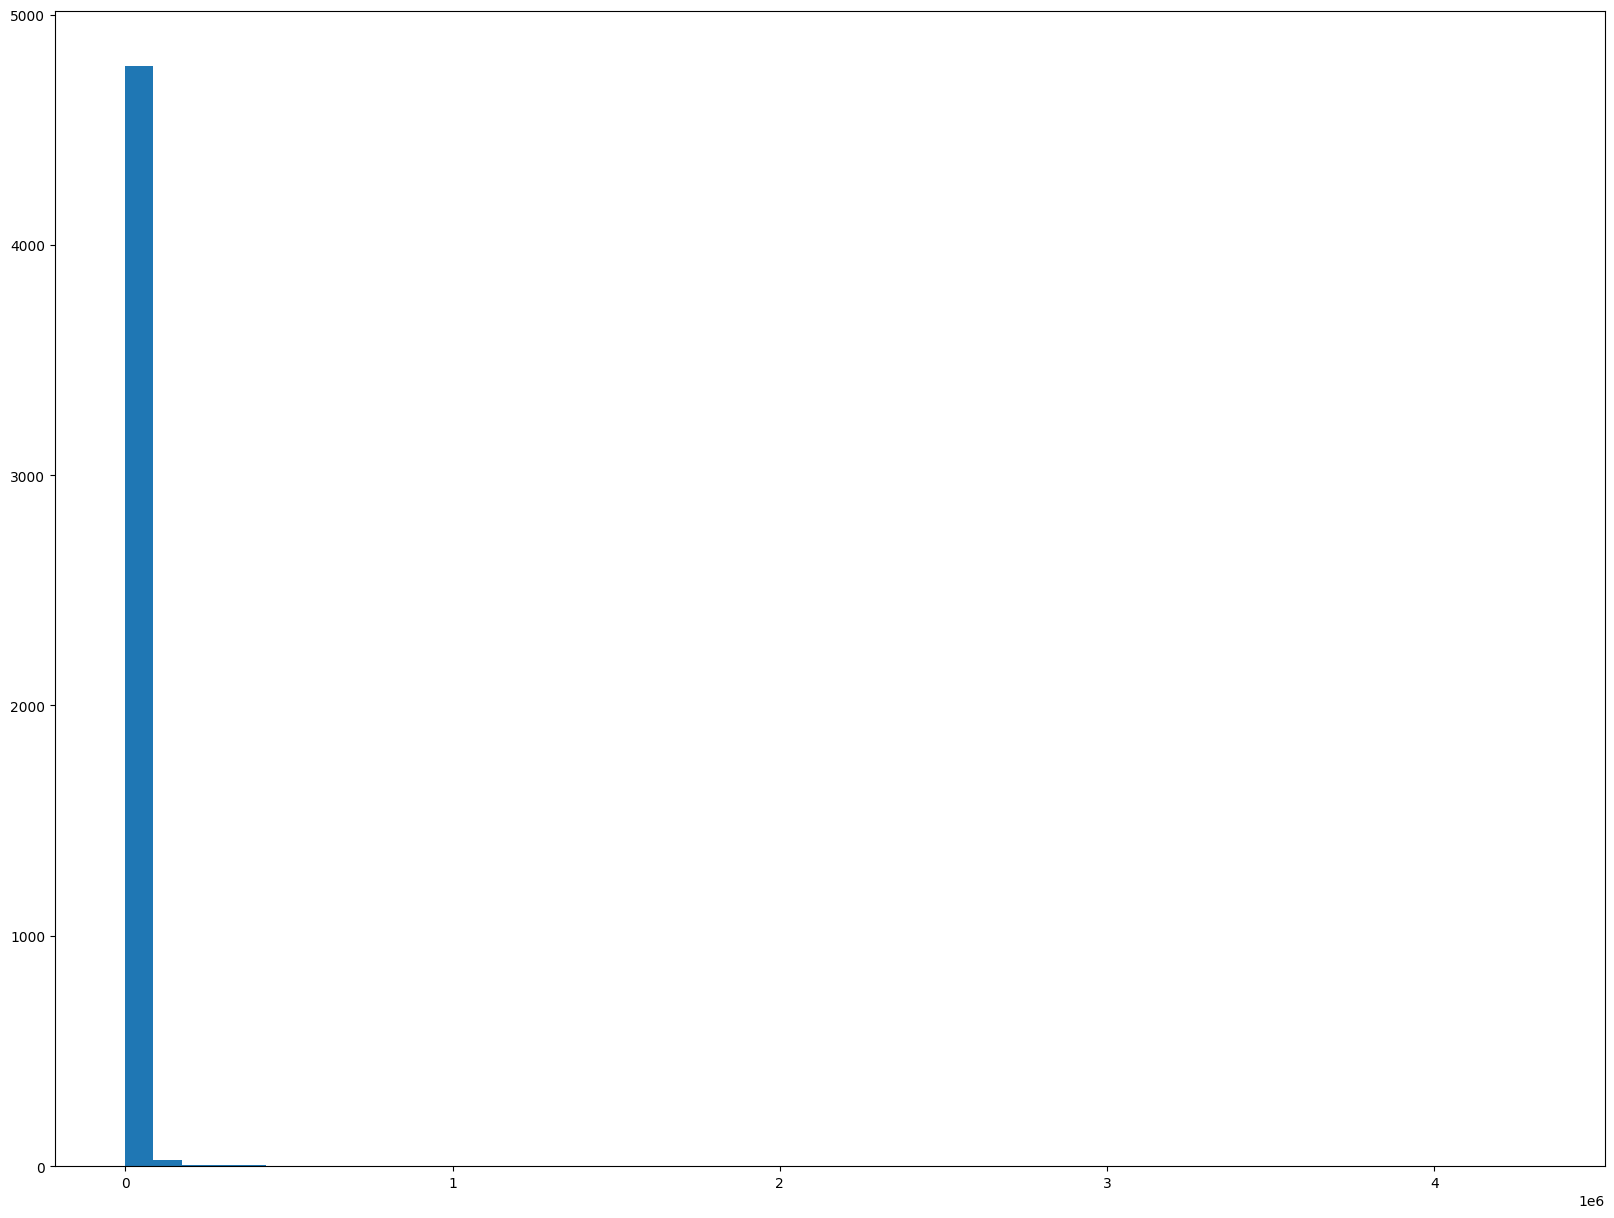

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
x = attribute_df["location"].value_counts()["location"]
y = attribute_df["location"].value_counts()["count"]
ax.hist(y, bins=50)
plt.plot()

In [23]:
attribute_df["location"].value_counts()["count"].describe()

statistic,value
str,f64
"""count""",4822.0
"""null_count""",0.0
"""mean""",4696.53484
"""std""",70155.823901
"""min""",1.0
"""25%""",17.0
"""50%""",217.0
"""75%""",723.0
"""max""",4.305927e6


[]

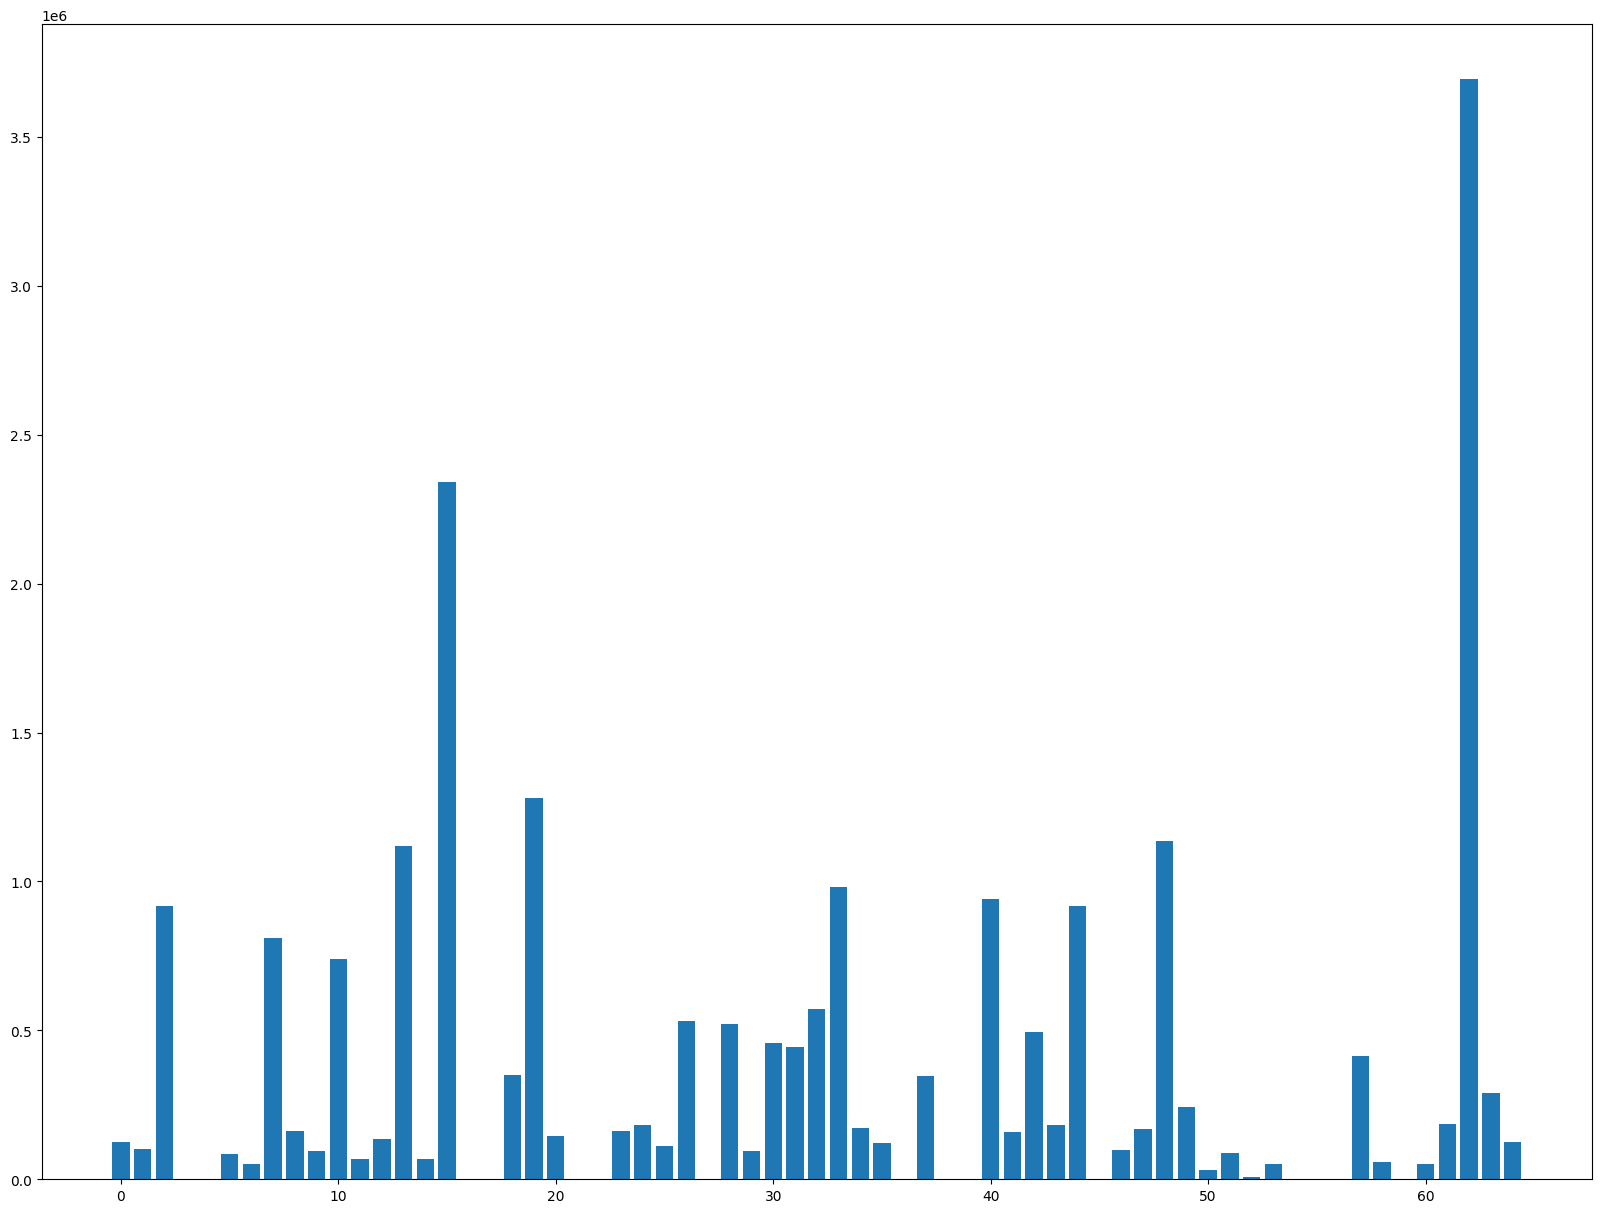

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
x = attribute_df["category"].value_counts()["category"]
y = attribute_df["category"].value_counts()["count"]
ax.bar(x, y)
plt.plot()

In [34]:
attribute_df["category"].value_counts()["count"].describe()

statistic,value
str,f64
"""count""",52.0
"""null_count""",0.0
"""mean""",435513.288462
"""std""",636940.742882
"""min""",2.0
"""25%""",96081.0
"""50%""",171834.0
"""75%""",520896.0
"""max""",3.693923e6
